In [7]:
import pandas as pd
import glob
import os

# Set folder path
folder_path = '/Users/user/Downloads/Wyscout Men - July/2025/'

# Load all Excel files in the folder
all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
df_list = [pd.read_excel(f) for f in all_files]
df = pd.concat(df_list, ignore_index=True)

# Filter: Age <= 23 and Minutes >= 300
df_filtered = df[(df['Age'] <= 23) & (df['Minutes played'] >= 300)].copy()

# Convert stats to per 30 minutes
for col in ['Goals', 'xG', 'Assists', 'xA']:
    df_filtered[col + '_per30'] = df_filtered[col] / df_filtered['Minutes played'] * 30

# Calculate IQR for Goals_per30
q1 = df_filtered['Goals_per30'].quantile(0.25)
q3 = df_filtered['Goals_per30'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Get only upper-bound outliers
outliers = df_filtered[df_filtered['Goals_per30'] > upper_bound]

# Save to Excel with two sheets
output_path = '/Users/user/Downloads/Wyscout Men - July/2025/filtered_players_with_outliers.xlsx'
with pd.ExcelWriter(output_path) as writer:
    df_filtered.to_excel(writer, index=False, sheet_name='Filtered Players')
    outliers.to_excel(writer, index=False, sheet_name='Goals_per30 Outliers')


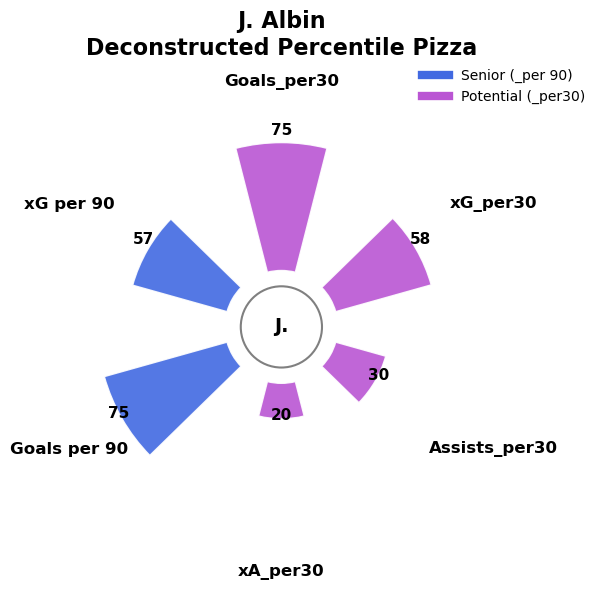

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from matplotlib.patches import Circle
from matplotlib.lines import Line2D  # for custom legend

def deconstructed_pizza_plot(df, player_name, metrics, inner_radius=25, center_circle_radius=18):
    """
    Deconstructed pizza chart with custom color coding and legend.
    Purple = Potential (_per30), Blue = Senior (_per 90).
    """
    player_df = df[df['Player'] == player_name]

    if player_df.empty:
        print(f"❌ Player '{player_name}' not found in dataset.")
        available = df['Player'].unique()
        print(f"✅ Available players: {available[:5]}...")
        return

    player = player_df.iloc[0]
    raw_percentiles = [percentileofscore(df[m], player[m]) for m in metrics]

    # Normalize percentile bars from inner_radius to 100
    full_range = 100 - inner_radius
    scaled_percentiles = [inner_radius + (p / 100) * full_range for p in raw_percentiles]
    bar_heights = [sp - inner_radius for sp in scaled_percentiles]

    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)

    # Assign colors: purple for _per30, blue for others
    colors = ['mediumorchid' if 'per30' in m.lower() else 'royalblue' for m in metrics]

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'polar'})
    bar_width = 0.5

    # Draw colored bars
    bars = ax.bar(
        angles,
        bar_heights,
        width=bar_width,
        bottom=inner_radius,
        color=colors,
        edgecolor='white',
        alpha=0.9
    )

    # Polar setup
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 100)
    ax.set_yticks([])
    ax.set_xticks(angles)
    ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')

    # Add value labels
    for angle, height, raw_pct in zip(angles, bar_heights, raw_percentiles):
        ax.text(
            angle,
            inner_radius + height + 2,
            f"{int(raw_pct)}",
            ha='center',
            va='bottom',
            fontsize=11,
            weight='bold'
        )

    # Add central circle
    center_circle = Circle((0, 0), center_circle_radius, transform=ax.transData._b,
                           facecolor='white', edgecolor='gray', lw=1.5, zorder=10)
    ax.add_patch(center_circle)

    # Name in center
    ax.text(0, 0, player_name.split()[0], fontsize=14, fontweight='bold',
            ha='center', va='center', zorder=11)

    # Custom legend
    legend_elements = [
        Line2D([0], [0], color='royalblue', lw=6, label='Senior (_per 90)'),
        Line2D([0], [0], color='mediumorchid', lw=6, label='Potential (_per30)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1.1), frameon=False)

    # Final styling
    ax.spines['polar'].set_visible(False)
    ax.grid(False)
    ax.set_facecolor('#ffffff')
    ax.set_title(f"{player_name}\nDeconstructed Percentile Pizza", va='bottom', fontsize=16, weight='bold', pad=30)

    plt.tight_layout()
    plt.show()

# Example usage
metrics = ['Goals_per30', 'xG_per30', 'Assists_per30', 'xA_per30', 'Goals per 90', 'xG per 90']
example_name = df_filtered['Player'].iloc[0]
deconstructed_pizza_plot(
    df_filtered,
    player_name=example_name,
    metrics=metrics,
    inner_radius=25,
    center_circle_radius=18
)


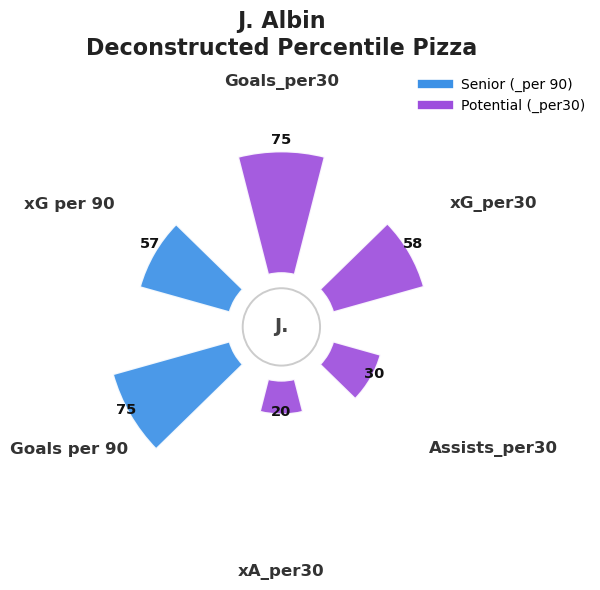

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

def deconstructed_pizza_plot(df, player_name, metrics, inner_radius=25, center_circle_radius=18):
    """
    Modern deconstructed pizza chart with spacing between central circle and slices.
    - Purple = Potential (_per30)
    - Blue = Senior (_per 90)
    """
    player_df = df[df['Player'] == player_name]
    if player_df.empty:
        print(f"❌ Player '{player_name}' not found in dataset.")
        print(f"✅ Available players: {df['Player'].unique()[:5]}")
        return

    player = player_df.iloc[0]
    raw_percentiles = [percentileofscore(df[m], player[m]) for m in metrics]

    # Normalize percentile heights (start at inner_radius, go to 100)
    full_range = 100 - inner_radius
    scaled_percentiles = [inner_radius + (p / 100) * full_range for p in raw_percentiles]
    bar_heights = [sp - inner_radius for sp in scaled_percentiles]

    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)

    # Color logic
    color_potential = '#9D4EDD'  # deep purple
    color_senior = '#3C91E6'     # modern blue
    bar_colors = [color_potential if 'per30' in m.lower() else color_senior for m in metrics]

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'polar'})
    bar_width = 0.5

    # Draw bars
    bars = ax.bar(
        angles,
        bar_heights,
        width=bar_width,
        bottom=inner_radius,
        color=bar_colors,
        edgecolor='white',
        linewidth=1.5,
        alpha=0.92,
        zorder=3
    )

    # Polar setup
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 105)  # ⬅️ Ensures the air gap is shown
    ax.set_yticks([])
    ax.set_xticks(angles)
    ax.set_xticklabels(metrics, fontsize=12, fontweight='semibold', color='#333333')

    # Value labels
    for angle, height, raw_pct in zip(angles, bar_heights, raw_percentiles):
        ax.text(
            angle,
            inner_radius + height + 2,
            f"{int(raw_pct)}",
            ha='center',
            va='bottom',
            fontsize=10.5,
            fontweight='bold',
            color='#111111'
        )

    # Center circle
    center_circle = Circle((0, 0), center_circle_radius, transform=ax.transData._b,
                           facecolor='white', edgecolor='#cccccc', lw=1.4, zorder=10)
    ax.add_patch(center_circle)

    # Player name in center
    ax.text(0, 0, player_name.split()[0], fontsize=14, fontweight='bold',
            ha='center', va='center', color='#444444', zorder=11)

    # Legend
    legend_elements = [
        Line2D([0], [0], color=color_senior, lw=6, label='Senior (_per 90)'),
        Line2D([0], [0], color=color_potential, lw=6, label='Potential (_per30)')
    ]
    ax.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(1.2, 1.08),
        frameon=False,
        fontsize=10
    )

    # Title
    ax.set_title(
        f"{player_name}\nDeconstructed Percentile Pizza",
        va='bottom',
        fontsize=16,
        weight='bold',
        pad=30,
        color='#222222'
    )

    # Aesthetic polish
    ax.spines['polar'].set_visible(False)
    ax.grid(False)
    ax.set_facecolor('#ffffff')

    plt.tight_layout()
    plt.show()

# Example usage
metrics = ['Goals_per30', 'xG_per30', 'Assists_per30', 'xA_per30', 'Goals per 90', 'xG per 90']
example_name = df_filtered['Player'].iloc[0]  # Replace as needed
deconstructed_pizza_plot(
    df_filtered,
    player_name=example_name,
    metrics=metrics,
    inner_radius=25,
    center_circle_radius=18  # This creates the air gap
)


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
from math import pi
from scipy.stats import percentileofscore

# === CONFIG ===
theme_bg = "#0B0C10"
primary = "#66fcf1"
accent = "#C5C6C7"
text_color = "#FFFFFF"
font = "DejaVu Sans"  # fallback sans-serif

# === Load Data ===
xls = pd.ExcelFile("/Users/user/Downloads/Wyscout Men - July/2024-2025/Germany III 2024-2025.xlsx")
df = xls.parse('Search results (500)')
outfield_df = df[df['Position'] != 'GK'].copy()
selected_player = outfield_df.iloc[0]
player_name = selected_player['Player']

# === Define Metrics ===
pizza_metrics_keys = [
    'Goals per 90', 'xG per 90', 'Assists per 90', 'xA per 90',
    'Shots per 90', 'Dribbles per 90', 'Progressive runs per 90',
    'Touches in box per 90', 'Key passes per 90', 'Progressive passes per 90'
]
bar_metrics_keys = [
    'Goals per 90', 'xG per 90', 'Assists per 90', 'xA per 90',
    'Shots per 90', 'Dribbles per 90', 'Touches in box per 90', 'Key passes per 90'
]

# === Calculate Percentiles ===
pizza_percentiles = {
    metric: percentileofscore(outfield_df[metric].dropna(), selected_player[metric])
    for metric in pizza_metrics_keys
}
bar_percentiles = {
    metric: percentileofscore(outfield_df[metric].dropna(), selected_player[metric])
    for metric in bar_metrics_keys
}

# === PIZZA PLOT ===
pizza_df = pd.DataFrame.from_dict(pizza_percentiles, orient='index', columns=['Percentile'])
labels = pizza_df.index.tolist()
values = pizza_df['Percentile'].tolist() + [pizza_df['Percentile'].tolist()[0]]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))] + [0]

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
fig.patch.set_facecolor(theme_bg)
ax.set_facecolor(theme_bg)
ax.plot(angles, values, linewidth=2, linestyle='solid', color=primary)
ax.fill(angles, values, color=primary, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, color=text_color, size=9, fontname=font)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], color=accent, size=8)
ax.set_title(f"{player_name} – Pizza Plot (Percentiles)", color=primary, size=13, weight='bold', pad=20)
pizza_path = "pizza_plot.png"
plt.tight_layout()
plt.savefig(pizza_path, dpi=300, facecolor=fig.get_facecolor())
plt.close()

# === BAR PLOT ===
stats_df = pd.DataFrame(bar_percentiles.items(), columns=["Metric", "Percentile"]).sort_values("Percentile")
plt.figure(figsize=(8, 6))
sns.set_style("dark")
sns.set_context("notebook")
ax = sns.barplot(data=stats_df, x="Percentile", y="Metric", palette="Blues_d")
plt.title(f"{player_name} – Bar Plot (Percentiles)", fontsize=13, color=primary, weight='bold', pad=15)
plt.xlabel("Percentile", color=text_color)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.xticks(color=text_color)
plt.yticks(color=text_color)
plt.gca().set_facecolor(theme_bg)
plt.gcf().patch.set_facecolor(theme_bg)
barplot_path = "bar_plot.png"
plt.tight_layout()
plt.savefig(barplot_path, dpi=300, facecolor=theme_bg)
plt.close()

# === BEESWARM PLOT ===
selected_metrics = ['Goals per 90', 'xG per 90', 'Assists per 90', 'xA per 90', 'Shots per 90']
melted_df = pd.melt(outfield_df[selected_metrics].dropna(), var_name="Metric", value_name="Value")
plt.figure(figsize=(8, 6))
sns.set_style("dark")
ax = sns.swarmplot(data=melted_df, x="Value", y="Metric", size=4, palette="coolwarm", alpha=0.9)
plt.title("Beeswarm Plot – Attacking Stats", fontsize=13, color=primary, weight='bold')
plt.xlabel("Per 90", color=text_color)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.xticks(color=text_color)
plt.yticks(color=text_color)
plt.gca().set_facecolor(theme_bg)
plt.gcf().patch.set_facecolor(theme_bg)
beeswarm_path = "beeswarm_plot.png"
plt.tight_layout()
plt.savefig(beeswarm_path, dpi=300, facecolor=theme_bg)
plt.close()

# === DISTRIBUTION PLOT ===
metric = "Progressive passes per 90"
plt.figure(figsize=(8, 6))
sns.set_style("dark")
sns.histplot(data=outfield_df, x=metric, bins=30, kde=True, color=primary, edgecolor=None)
plt.axvline(x=selected_player[metric], color='red', linestyle='--', label=player_name)
plt.title(f"{metric} Distribution", fontsize=13, color=primary, weight='bold')
plt.xlabel("Per 90", color=text_color)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.xticks(color=text_color)
plt.yticks(color=text_color)
plt.gca().set_facecolor(theme_bg)
plt.gcf().patch.set_facecolor(theme_bg)
distplot_path = "distribution_plot.png"
plt.tight_layout()
plt.savefig(distplot_path, dpi=300, facecolor=theme_bg)
plt.close()

# === COMBINE ALL PLOTS ===
target_size = (1000, 800)
pizza_img = Image.open(pizza_path).resize(target_size)
bar_img = Image.open(barplot_path).resize(target_size)
beeswarm_img = Image.open(beeswarm_path).resize(target_size)
distplot_img = Image.open(distplot_path).resize(target_size)

final_width = target_size[0] * 2
final_height = target_size[1] * 2
combined_image = Image.new('RGB', (final_width, final_height), (11, 12, 16))  # match dark background

combined_image.paste(pizza_img, (0, 0))
combined_image.paste(bar_img, (target_size[0], 0))
combined_image.paste(beeswarm_img, (0, target_size[1]))
combined_image.paste(distplot_img, (target_size[0], target_size[1]))

combined_path = "combined_dashboard.png"
combined_image.save(combined_path)

print(f"✅ Dashboard complete for {player_name}")
print("📁 Saved to:", combined_path)


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25402/3192652750.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=stats_df, x="Percentile", y="Metric", palette="Blues_d")
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25402/3192652750.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(data=melted_df, x="Value", y="Metric", size=4, palette="coolwarm", alpha=0.9)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 60.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical

✅ Dashboard complete for P. Sontheimer
📁 Saved to: combined_dashboard.png
